# Case Study: Change Point Detection

**Figure 6e**

In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import changeforest

## Auxiliary functions

### Plotting

In [4]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rcParams.update({'font.size': 7})
MM = 1/25.4 # inches to mm

In [5]:
colors = np.array([(12,234,217), (58,202,223), (114,158,253), (138,100,214), (92,58,146)])

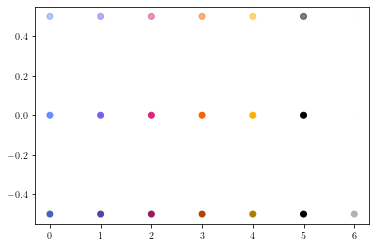

In [6]:
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [7]:
def norm(x):
    xx = x - x.min()
    return xx / xx.max()

## Task: recover change points from wind tunnel time-series

### Load dataset

In [8]:
#from causalchamber import datasets
from causalchamber.datasets import Dataset
dataset = Dataset("wt_changepoints_v1", root='/tmp')
dataset.available_experiments()

If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={(work in progress)},
  year={2023}
}


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
Dataset wt_changepoints_v1 found in "/tmp/wt_changepoints_v1".


['load_in_seed_4',
 'load_in_seed_3',
 'load_in_seed_7',
 'load_in_seed_9',
 'load_in_seed_8',
 'load_in_seed_6',
 'load_in_seed_2',
 'load_in_seed_5',
 'load_in_seed_1',
 'load_in_seed_0']

In [9]:
df = dataset.get_experiment('load_in_seed_9').as_pandas_dataframe()

### Apply the changeforest algorithm [1] and plot results

In [10]:
from changeforest import changeforest
def forest_estimate(X):
    result = changeforest(np.atleast_2d(X).T, "random_forest", "bs")
    return result.split_points()

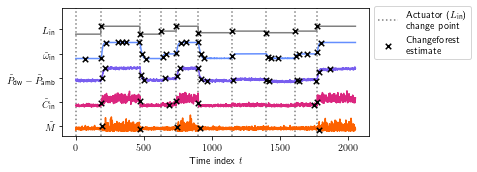

In [11]:
#df = pd.read_csv("/home/juan/ETH/causal_room/datasets/wt_changepoints/data/2023_12_28-23_05_25_wt_load_in_seed_9.csv")

plt.figure(figsize=(140*MM,60*MM))

d = 1.5
ms = 30

changepoints = list(df[df.intervention==1].index)
for j,p in enumerate(changepoints):
    plt.axvline(p, color='gray', linestyle=':', label=r"Actuator ($L_\text{in}$)"+"\nchange point " if j == 0 else None)

# Applied to load_in
X = df.load_in
plt.plot(X, color='gray')
estimate = forest_estimate(X)
plt.scatter(estimate,X[estimate],marker='x',color='black',zorder=10,s=ms)

# Applied to rpm_in
i = 1
X = df.rpm_in
plt.plot(norm(X)-d*i, color=base[i-1])
estimate = forest_estimate(X)
plt.scatter(estimate,norm(X)[estimate]-d*i,marker='x',color='black',zorder=10,s=ms)

# Applied to pressure_downwind - pressure_ambient
i = 2
X = df.pressure_downwind-df.pressure_ambient
plt.plot(norm(X)-d*i, color=base[i-1])
estimate = forest_estimate(X)
plt.scatter(estimate,norm(X)[estimate]-d*i,marker='x',color='black',zorder=10,s=ms)

# Applied to current_in
i = 3
X = df.current_in
plt.plot(norm(X)-d*i, color=base[i-1])
estimate = forest_estimate(X)
plt.scatter(estimate,norm(X)[estimate]-d*i,marker='x',color='black',zorder=10,s=ms)

# Applied to mic
i = 4
X = df.mic
plt.plot(norm(X)-d*i, color=base[i-1])
estimate = forest_estimate(X)
plt.scatter(estimate,norm(X)[estimate]-d*i,marker='x',color='black',zorder=10,label="Changeforest\nestimate",s=ms)

labels = [r'$L_\text{in}$',
          r'$\tilde{\omega}_\text{in}$',
          r'$\tilde{P}_\text{dw} - \tilde{P}_\text{amb}$',
          r'$\tilde{C}_\text{in}$',
          r'$\tilde{M}$',
         ]
plt.yticks(-d * np.arange(5) + 0.3, labels)
plt.xlabel("Time index $t$")
plt.legend(bbox_to_anchor=(1,1.05), loc="upper left", ncol=1)
plt.ylim([-4.2*d,d*1.1])
plt.savefig("../figures/changepoints.pdf", bbox_inches="tight")

## References

[1] Londschien, Malte, Peter Bühlmann, and Solt Kovács. "Random forests for change point detection."_Journal of Machine Learning Research_ 24.216 (2023): 1-45.